# Train With Extra Tree Classifier Features Selection

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patheffects as path_effects
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.patheffects as path_effects
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder,OneHotEncoder,MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report,roc_auc_score,roc_curve, auc
import time
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.inspection import permutation_importance
import time
data = pd.read_csv('BankChurners.csv')#read csv file

In [2]:
data.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [3]:
cols = data.columns
num_cols = data._get_numeric_data().columns
categorical = list(set(cols) - set(num_cols))

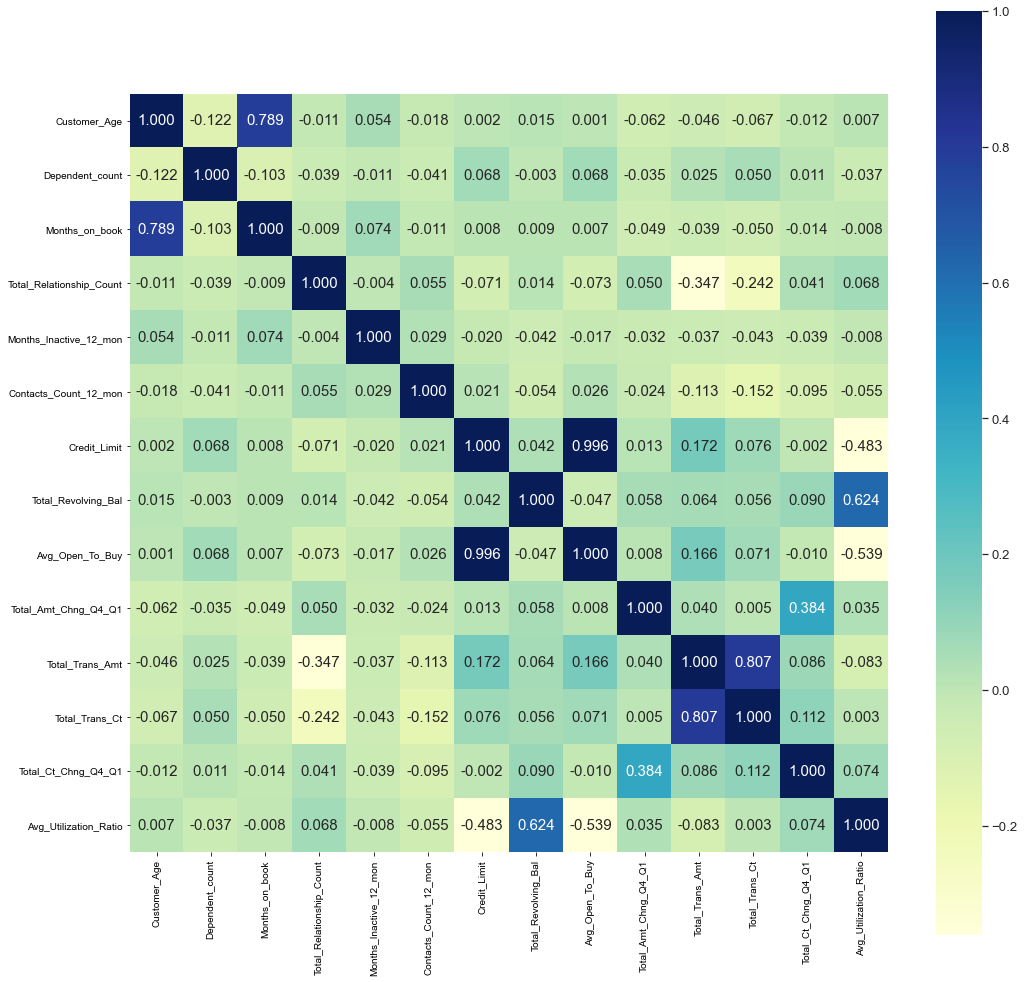

In [4]:
# numerical_data = data[['Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count'
#                               ,'Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal'
#                               ,'Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct',
#                               'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']]

# corrMatrix = numerical_data.corr()

num_cols = data._get_numeric_data().columns
corrMatrix = data.loc[:, num_cols].corr()

plt.subplots(figsize=(17,17))
sns.set_style('darkgrid')
sns.set(font_scale=1.2)
sns.heatmap(corrMatrix,
            annot=True,
            cmap="YlGnBu",
            fmt=".3f",
            annot_kws={'size':15},
            robust=True,
            square=True)
plt.show()

From the correlation table above, it indicate that the customer's period of relationship with the bank is correlated with the customer age positively. And the average of open to buy credit line is also directly correlated with the customer's credit limit on their credit cards. Next, the average utilization ratio is also correlated positively with the total revolving balance on the credit card of the customers. Lastly, the customers' total transaction count is also correlated positively with the total transaction amount.

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.select_dtypes(include=[np.number]).columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    corr = df.select_dtypes(include=[np.number]).corr()
    au_corr = corr.abs().unstack()
    labels_to_drop = get_redundant_pairs(df.select_dtypes(include=[np.number]))
    #From corrolation table, drop the diagonals(which gives 1 corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data, 10))

Top Absolute Correlations
Credit_Limit              Avg_Open_To_Buy          0.995981
Total_Trans_Amt           Total_Trans_Ct           0.807192
Customer_Age              Months_on_book           0.788912
Total_Revolving_Bal       Avg_Utilization_Ratio    0.624022
Avg_Open_To_Buy           Avg_Utilization_Ratio    0.538808
Credit_Limit              Avg_Utilization_Ratio    0.482965
Total_Amt_Chng_Q4_Q1      Total_Ct_Chng_Q4_Q1      0.384189
Total_Relationship_Count  Total_Trans_Amt          0.347229
                          Total_Trans_Ct           0.241891
Credit_Limit              Total_Trans_Amt          0.171730
dtype: float64


## Check distribution of numerical data


In [6]:
float_columns = [x for x in data.columns if x in data.select_dtypes('number')]
float_columns

#Plt histogram on numerical data
# data.hist(figsize=(30,16), xrot=15, bins=int(data.shape[0]**0.5));

#Print Sknewness if skew value exceed 0.75
print("Numerical column skewness value > 0.75")
print("======================================")
skew_columns = (data[float_columns]
                .skew()
                .sort_values(ascending=False))
##print (skew_columns)
log_columns = skew_columns.loc[skew_columns > 0.75]
print (log_columns)


Numerical column skewness value > 0.75
Total_Ct_Chng_Q4_Q1     2.064031
Total_Trans_Amt         2.041003
Total_Amt_Chng_Q4_Q1    1.732063
Credit_Limit            1.666726
Avg_Open_To_Buy         1.661697
dtype: float64


The histogram above show all the numerical data histogram graph to understand its distrubution.For better view, The code above show the numerical columns which exceed the skewness value of 0.75. The column that having skewness value that more than 0.75 means that it is not normal distribution.For the column that having skewness value less then 0.75 is normal distribution. By orserving the graph above, column which are not normal disribution normally does not have a regular bell shape. 

Some columns is selected and ploting in the histogram with density line in normal and actual. Based on the graph above, the customer age is normal distribution since its skewness value is lower than 0.75. Besides, this pot also show that there is a right skew on Total_Ct_Chng_Q4_Q1, Total_Trans_Amt, Total_Amt_Chng_Q4_Q1 ,Credit_Limit and Avg_Open_To_Buy.

 

In [7]:
data['Income_Category'] = data['Income_Category'].replace({
    'Unknown':0,
    'Less than $40K':1,
    '$40K - $60K':2,
    '$60K - $80K':3,
    '$80K - $120K':4,
    '$120K +':5
})

data['Gender'] = data['Gender'].replace({
    'M':0,
    'F':1,
})

data['Marital_Status'] = data['Marital_Status'].replace({
    'Unknown':0,
    'Single':1,
    'Married':2,
    'Divorced':3
})

data['Card_Category'] = data['Card_Category'].replace({
    'Blue':0,
    'Gold':1,
    'Platinum':2,
    'Silver':3
})

data['Education_Level'] = data['Education_Level'].replace({
    'Unknown':0,
    'Uneducated':1,
    'High School':2,
    'College':3,
    'Graduate':4,
    'Post-Graduate':5,
    'Doctorate':6
})


In [8]:
y = data[['Attrition_Flag']]
x = data.drop(columns=["Attrition_Flag"], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state = 0, stratify = y)

categorical_data = ['Gender','Education_Level','Marital_Status','Card_Category']

#x_train_categorical = x_train[categorical_data]
#x_test_categorical = x_test[categorical_data]
#x_train_numerical = x_train.drop(columns=categorical_data, axis = 1)
#x_test_numerical = x_test.drop(columns=categorical_data, axis = 1)

In [9]:
#after log tranform 
# Perform log transform on skewed columns
for col in log_columns.index.tolist():
    x[col] = np.log1p(x[col])


In [10]:
#label encoder label y 
def prepare_targets(y_train, y_test):
    labelencoder = LabelEncoder()
    labelencoder.fit(y_train)
    y_train_enc = labelencoder.transform(y_train)
    y_test_enc = labelencoder.transform(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train,y_test)

C:\Users\nigel\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [11]:
def prepare_inputs(x_train, x_test):
    mms = MinMaxScaler()
    x_train[num_cols] = mms.fit_transform(x_train[num_cols])
    x_test[num_cols] = mms.transform(x_test[num_cols])
    return x_train,x_test


    
#mix_maxscaler
x_train_process, x_test_process = prepare_inputs(x_train,x_test)


<ipython-input-11-0f0f5d993b2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[num_cols] = mms.fit_transform(x_train[num_cols])
C:\Users\nigel\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-11-0f0f5d993b2c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [12]:
# Visualising the accuracy score of each classification model

def plotEvaluationMetrics(models,y,title):
    plt.rcParams['figure.figsize']=15,8 
    sns.set_style("darkgrid")
    ax = sns.barplot(x=models, y=y, palette = "rocket", saturation =1.5)
    plt.xlabel("Classifier Models", fontsize = 20 )
    plt.ylabel("% of Accuracy", fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
    plt.yticks(fontsize = 13)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        xPlot, yPlot = p.get_xy() 
        ax.annotate(f'{height:.3%}', (xPlot + width/2, yPlot + height*1.02), ha='center', fontsize = 'x-large')
    plt.show()

In [13]:
# every model accuracy graph
models = ['LR','GNB','SVC','KNN', 'DTC', 'RFC', 'SGD','XGBoost']
# Visualising the accuracy score of each classification model

In [14]:
def roc_curve(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Correlation Table For Feature Selection

In [15]:
drop = ['Total_Trans_Amt','Dependent_count','Total_Revolving_Bal','Months_on_book']

x_train_nw = x_train_process.drop(drop,axis=1)

x_test_nw = x_test_process.drop(drop,axis=1)

def model_training(classifier,x_train,x_test):
    start = time.time()
    model = classifier.fit(x_train, y_train)
    stop = time.time()
    trainingTime = stop - start
    print(f"Training time: {trainingTime}s")

    # Predicting the test set
    y_pred = classifier.predict(x_test)

    # Making the confusion matrix and calculating accuracy score
    cm = confusion_matrix(y_test, y_pred)
    ac = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    acscore.append(ac)
    acprecision.append(precision)
    acrecall.append(recall)
    acF1.append(f1)
    acTrainingTime.append(trainingTime)

    sns.heatmap(cm, xticklabels=['Predicted Churn', 'Predicted Not Churn'], yticklabels=['Actual_Churn', 'Actual_Not_Churn'],
                annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    print('Accuracy score: {0:0.3f}'.format(ac))
    print('Precision score: {0:0.3f}'.format(precision))
    print('Recall score: {0:0.3f}'.format(recall))
    print('F1 score: {0:0.3f}'.format(f1))
    print('Training Accuracy: ',classifier.score(x_train, y_train))
    print('Testing Accuracy: ',classifier.score(x_test, y_test))
    target_names = ['churn', 'not churn']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    return model

def model_roc_curve(classifier,x_train,x_test):
    classifier.fit(x_train, y_train)
    predProb = classifier.predict_proba(x_test)
    preds = predProb[:,1]
    fpr, tpr,threshold = metrics.roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    roc_curve(fpr,tpr,roc_auc)
    

In [16]:
x_test_nw

,Customer_Age,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
5097,0.489362,1,2,2,1,0,0.8,0.500000,0.166667,0.046971,0.033147,0.208125,0.573643,0.201939,0.617618
6241,0.468085,0,5,1,3,0,1.0,0.500000,0.333333,0.132648,0.125779,0.214601,0.511628,0.206516,0.254254
4149,0.468085,0,0,2,4,0,0.6,0.500000,0.500000,0.155836,0.190943,0.196350,0.457364,0.207054,0.000000
9460,0.361702,0,4,1,4,0,0.2,0.333333,0.166667,0.997309,0.950685,0.207242,0.790698,0.180937,0.047047
6877,0.574468,1,4,2,2,0,0.4,0.833333,0.166667,0.047939,0.039753,0.172800,0.612403,0.182822,0.545546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750,0.234043,1,2,1,2,0,0.6,0.166667,0.333333,0.023149,0.037145,0.209597,0.558140,0.269251,0.417417
7577,0.659574,1,4,2,1,0,0.8,0.500000,0.333333,0.005765,0.012778,0.225493,0.565891,0.238557,0.727728
3458,0.510638,0,1,1,4,0,1.0,0.333333,0.000000,0.253092,0.230899,0.194583,0.240310,0.172321,0.187187
8907,0.404255,1,6,2,2,3,0.0,0.166667,0.500000,0.534157,0.526497,0.259052,0.612403,0.151050,0.049049


Training time: 0.1980600357055664s
Accuracy score: 0.894
Precision score: 0.906
Recall score: 0.975
F1 score: 0.939
Training Accuracy:  0.893058690744921
Testing Accuracy:  0.8937150378413952
              precision    recall  f1-score   support

       churn       0.78      0.47      0.59       488
   not churn       0.91      0.97      0.94      2551

    accuracy                           0.89      3039
   macro avg       0.84      0.72      0.76      3039
weighted avg       0.89      0.89      0.88      3039



LogisticRegression(max_iter=10000)

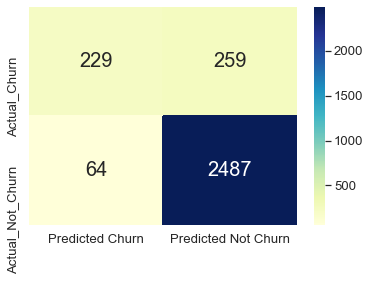

In [17]:
#Logistic Regression after correlation feature selection
acscore = []
acprecision = []
acrecall = []
acF1 = []
acTrainingTime = []
from sklearn.linear_model import LogisticRegression
model_training(LogisticRegression(max_iter=10000),x_train_nw,x_test_nw)

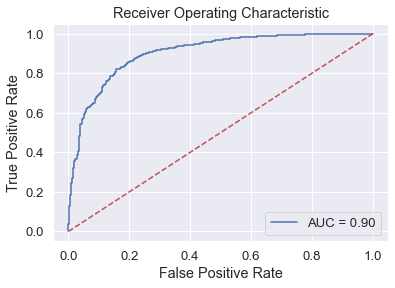

In [18]:
model_roc_curve(LogisticRegression(max_iter=10000),x_train_nw,x_test_nw)

Training time: 0.00598454475402832s
Accuracy score: 0.891
Precision score: 0.919
Recall score: 0.955
F1 score: 0.937
Training Accuracy:  0.8878386004514672
Testing Accuracy:  0.8914116485686081
              precision    recall  f1-score   support

       churn       0.70      0.56      0.62       488
   not churn       0.92      0.95      0.94      2551

    accuracy                           0.89      3039
   macro avg       0.81      0.76      0.78      3039
weighted avg       0.88      0.89      0.89      3039



GaussianNB()

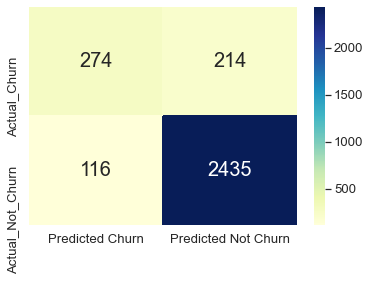

In [19]:
#Gaussian Naive Bayes after feature selection
model_training(GaussianNB(),x_train_nw,x_test_nw)

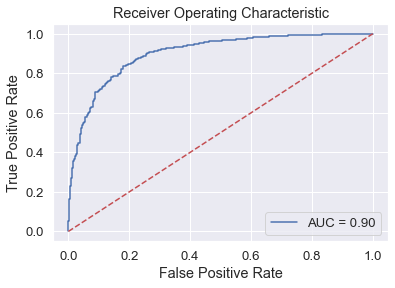

In [20]:
model_roc_curve(GaussianNB(),x_train_nw,x_test_nw)

Training time: 4.330122470855713s
Accuracy score: 0.888
Precision score: 0.887
Recall score: 0.993
F1 score: 0.937
Training Accuracy:  0.884734762979684
Testing Accuracy:  0.8877920368542284
              precision    recall  f1-score   support

       churn       0.91      0.34      0.49       488
   not churn       0.89      0.99      0.94      2551

    accuracy                           0.89      3039
   macro avg       0.90      0.66      0.71      3039
weighted avg       0.89      0.89      0.87      3039



SVC(probability=True)

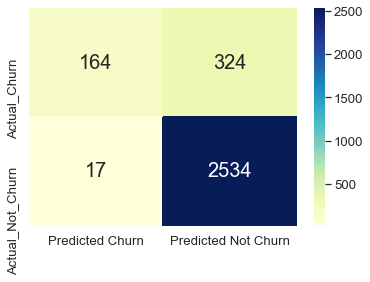

In [21]:
#SVC after feature selection
model_training(SVC(probability=True),x_train_nw,x_test_nw)

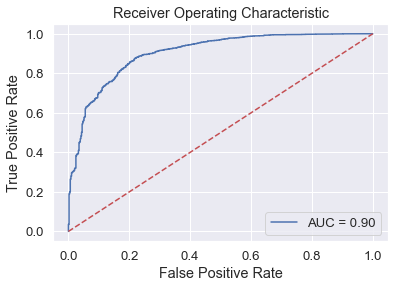

In [22]:
model_roc_curve(SVC(probability=True),x_train_nw,x_test_nw)

Training time: 0.04189014434814453s
Accuracy score: 0.860
Precision score: 0.873
Recall score: 0.976
F1 score: 0.922
Training Accuracy:  0.8893905191873589
Testing Accuracy:  0.8604804211911813
              precision    recall  f1-score   support

       churn       0.67      0.26      0.37       488
   not churn       0.87      0.98      0.92      2551

    accuracy                           0.86      3039
   macro avg       0.77      0.62      0.65      3039
weighted avg       0.84      0.86      0.83      3039



KNeighborsClassifier()

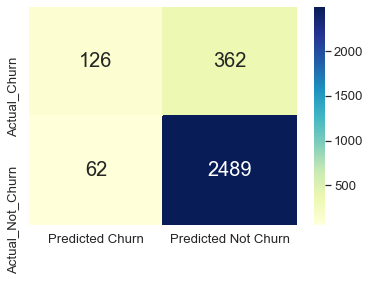

In [23]:
#KNN after feature selection
model_training(KNeighborsClassifier(),x_train_nw,x_test_nw)

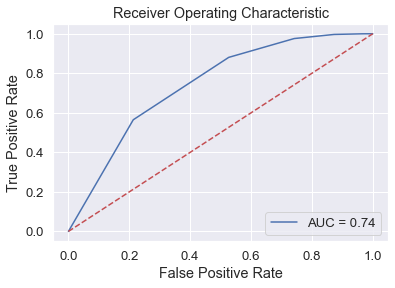

In [24]:
model_roc_curve(KNeighborsClassifier(),x_train_nw,x_test_nw)

Training time: 0.06138944625854492s
Accuracy score: 0.886
Precision score: 0.931
Recall score: 0.933
F1 score: 0.932
Training Accuracy:  1.0
Testing Accuracy:  0.8858177031918394
              precision    recall  f1-score   support

       churn       0.65      0.64      0.64       488
   not churn       0.93      0.93      0.93      2551

    accuracy                           0.89      3039
   macro avg       0.79      0.79      0.79      3039
weighted avg       0.89      0.89      0.89      3039



DecisionTreeClassifier()

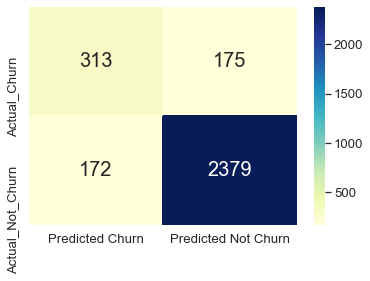

In [25]:
#DTC after feature selection
model_training(DecisionTreeClassifier(),x_train_nw,x_test_nw)

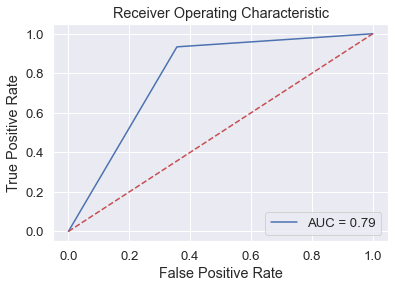

In [26]:
model_roc_curve(DecisionTreeClassifier(),x_train_nw,x_test_nw)

Training time: 0.9200472831726074s
Accuracy score: 0.935
Precision score: 0.941
Recall score: 0.983
F1 score: 0.962
Training Accuracy:  1.0
Testing Accuracy:  0.9345179335307667
              precision    recall  f1-score   support

       churn       0.89      0.68      0.77       488
   not churn       0.94      0.98      0.96      2551

    accuracy                           0.93      3039
   macro avg       0.91      0.83      0.87      3039
weighted avg       0.93      0.93      0.93      3039



RandomForestClassifier()

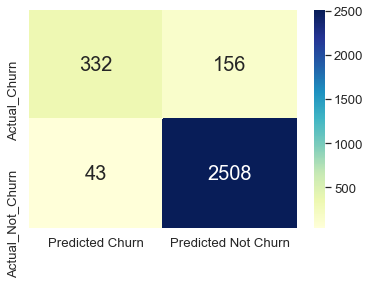

In [27]:
#RFC after feature selection
model_training(RandomForestClassifier(),x_train_nw,x_test_nw)

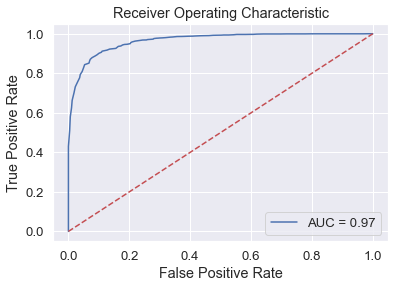

In [28]:
model_roc_curve(RandomForestClassifier(),x_train_nw,x_test_nw)

Training time: 0.03989052772521973s
Accuracy score: 0.893
Precision score: 0.911
Recall score: 0.968
F1 score: 0.938
Training Accuracy:  0.8954571106094809
Testing Accuracy:  0.8933859822309971
              precision    recall  f1-score   support

       churn       0.75      0.50      0.60       488
   not churn       0.91      0.97      0.94      2551

    accuracy                           0.89      3039
   macro avg       0.83      0.74      0.77      3039
weighted avg       0.88      0.89      0.88      3039



SGDClassifier(loss='log', shuffle=False)

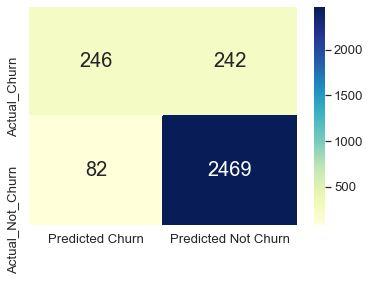

In [29]:
#SGD after feature selection
model_training(SGDClassifier(shuffle=False,loss="log"),x_train_nw,x_test_nw)

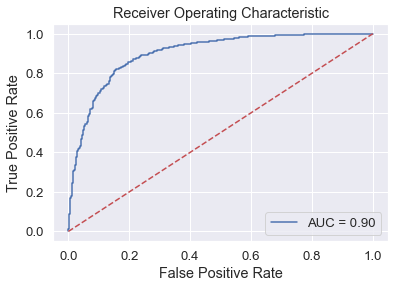

In [30]:
model_roc_curve(SGDClassifier(shuffle=False,loss="log"),x_train_nw,x_test_nw)

C:\Users\nigel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 0.6024162769317627s
Accuracy score: 0.934
Precision score: 0.949
Recall score: 0.973
F1 score: 0.961
Training Accuracy:  0.9974604966139955
Testing Accuracy:  0.9338598223099703
              precision    recall  f1-score   support

       churn       0.84      0.73      0.78       488
   not churn       0.95      0.97      0.96      2551

    accuracy                           0.93      3039
   macro avg       0.89      0.85      0.87      3039
weighted avg       0.93      0.93      0.93      3039



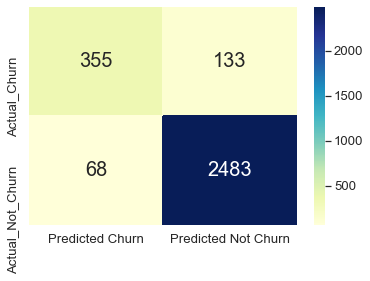

In [31]:
#XGB after feature selection
xgbmodel1 = model_training(xgb.XGBClassifier(),x_train_nw,x_test_nw)

[23:25:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


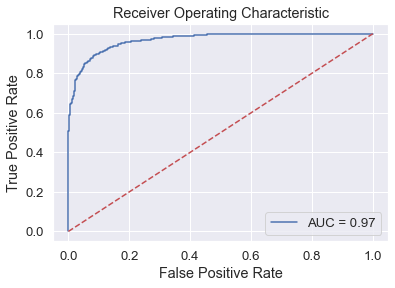

In [32]:
model_roc_curve(xgb.XGBClassifier(),x_train_nw,x_test_nw)

In [33]:
x_process_concat = pd.concat([x_train_nw,x_test_nw])
y_concat =  np.concatenate((y_train, y_test), axis=None)

In [34]:
from sklearn.model_selection import cross_val_score

CVMean = []
CVSD = []

tupleModel = [LogisticRegression(random_state=0,max_iter=10000),GaussianNB(),SVC(probability=True),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),SGDClassifier(loss="log"),xgb.XGBClassifier()]
a = 0
for model in models:
    model = cross_val_score(tupleModel[a],x_process_concat, y_concat,cv=5,scoring='accuracy')
    print(models[a],":",model)
    CVMean.append(model.mean())
    CVSD.append(model.std())
    a+=1

LR : [0.89141165 0.88499506 0.89382716 0.8982716  0.89728395]
GNB : [0.88203356 0.88252715 0.89333333 0.88049383 0.8962963 ]
SVC : [0.87611056 0.88548865 0.88592593 0.88740741 0.88938272]
KNN : [0.86179664 0.85735439 0.8637037  0.85975309 0.86469136]
DTC : [0.89733465 0.89091807 0.89333333 0.89432099 0.89580247]
RFC : [0.92349457 0.92448174 0.9308642  0.93234568 0.93382716]
SGD : [0.89239882 0.88943731 0.88790123 0.89679012 0.89580247]
[23:26:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nigel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

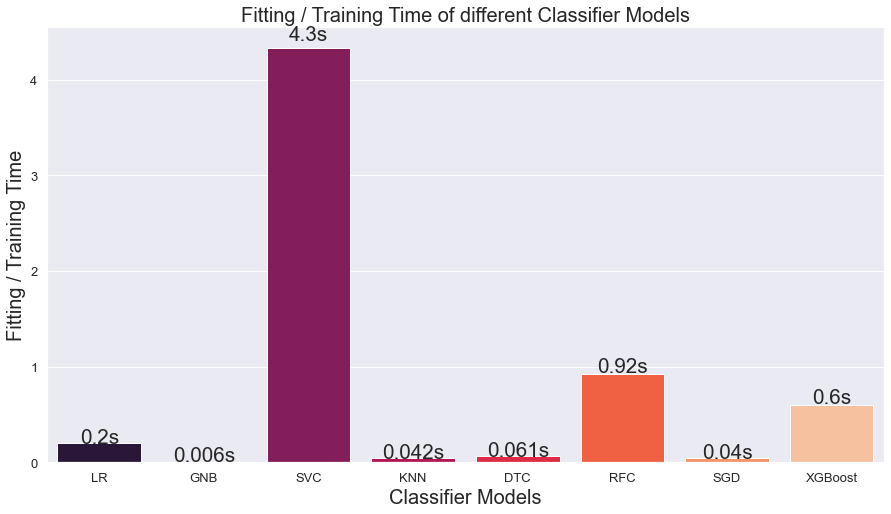

In [35]:
plt.rcParams['figure.figsize']=15,8 
sns.set_style("darkgrid")
ax = sns.barplot(x=models, y=acTrainingTime, palette = "rocket", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("Fitting / Training Time", fontsize = 20)
plt.title("Fitting / Training Time of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    xPlot, yPlot = p.get_xy() 
    ax.annotate(f'{height:.2}''s', (xPlot + width/2, yPlot + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

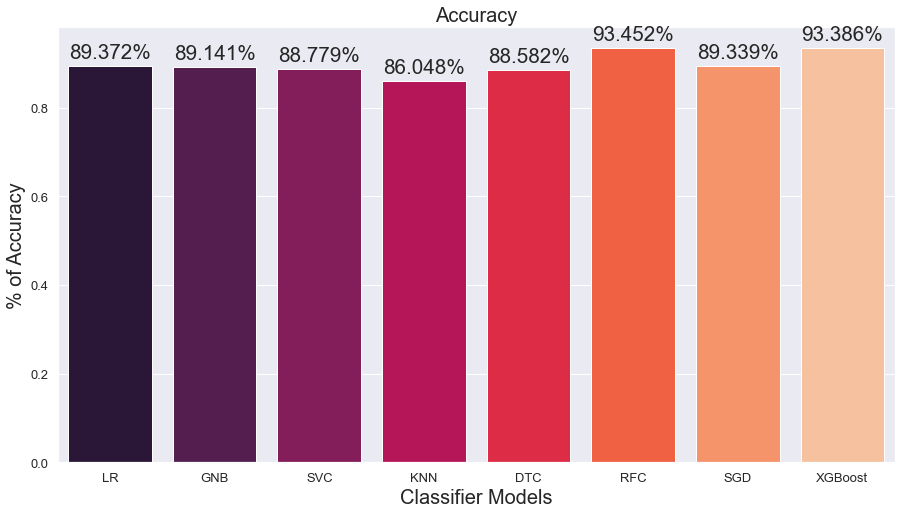

In [36]:
plotEvaluationMetrics(models,acscore,"Accuracy")

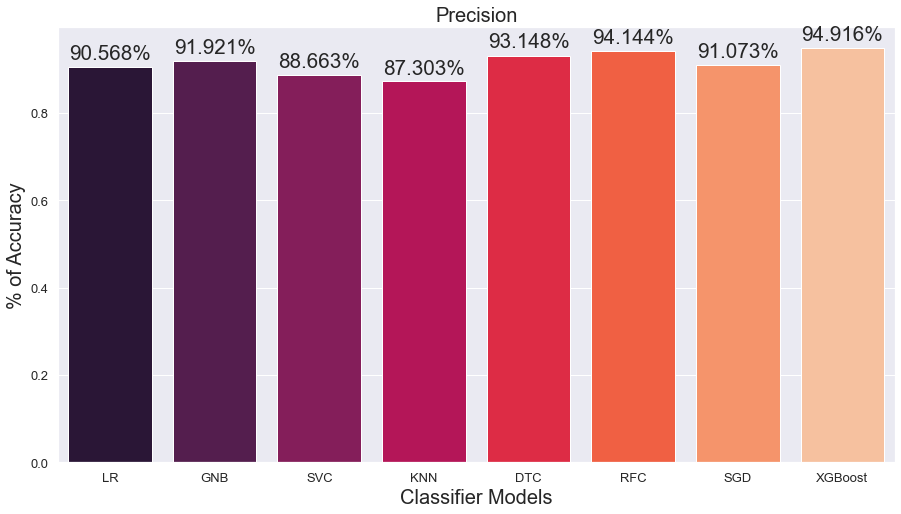

In [37]:
plotEvaluationMetrics(models,acprecision,"Precision")

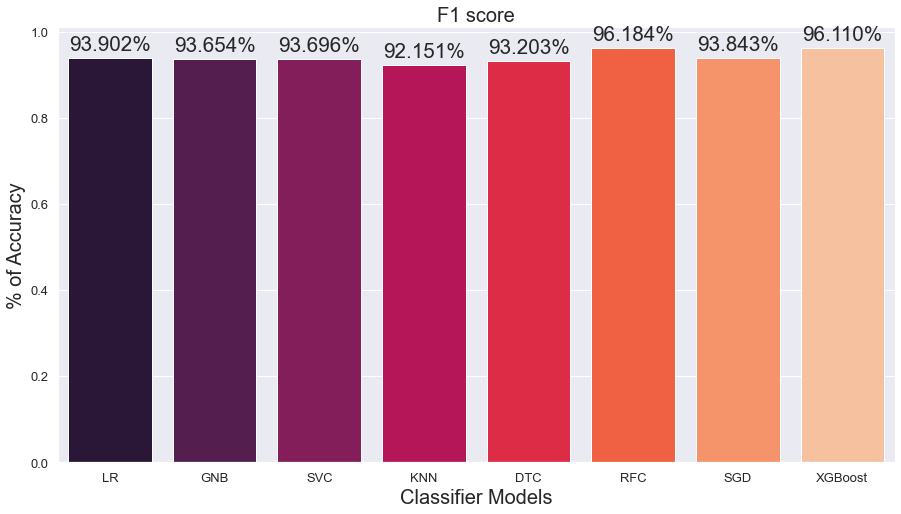

In [38]:
plotEvaluationMetrics(models,acF1,"F1 score")

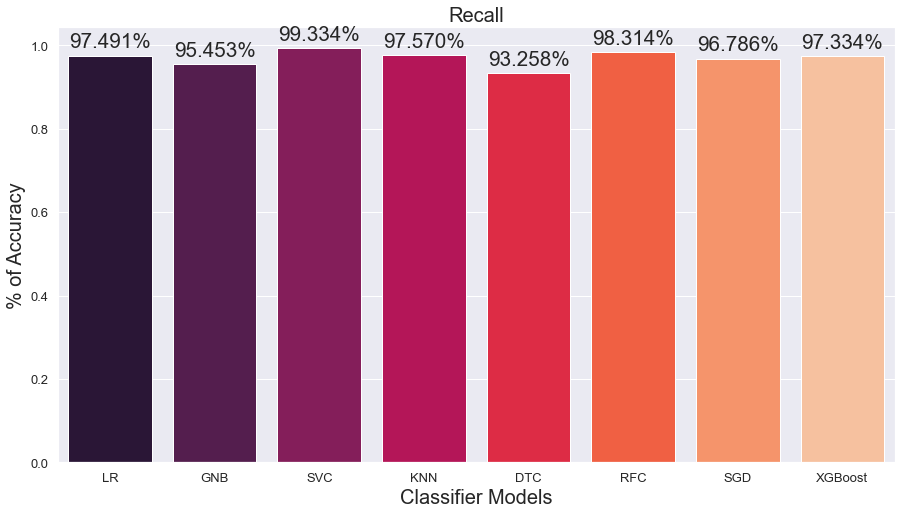

In [39]:
plotEvaluationMetrics(models,acrecall,"Recall")

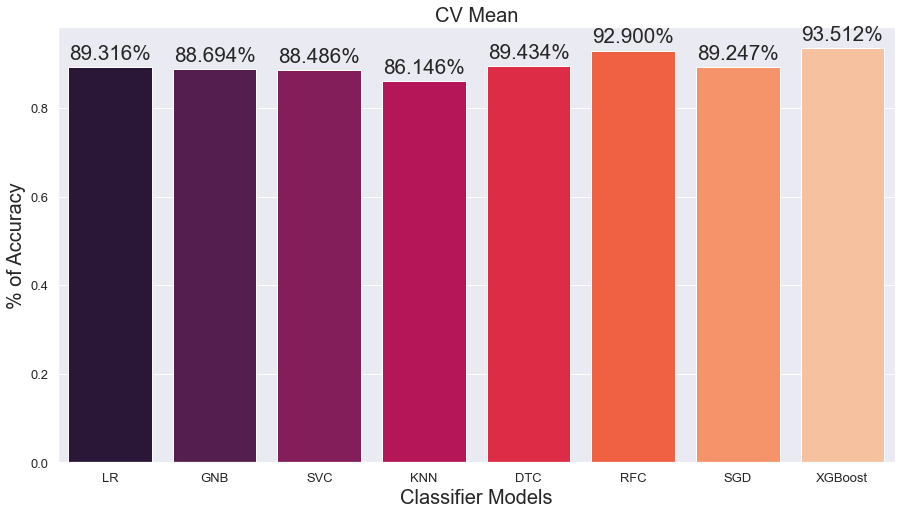

In [40]:
plotEvaluationMetrics(models,CVMean,"CV Mean")

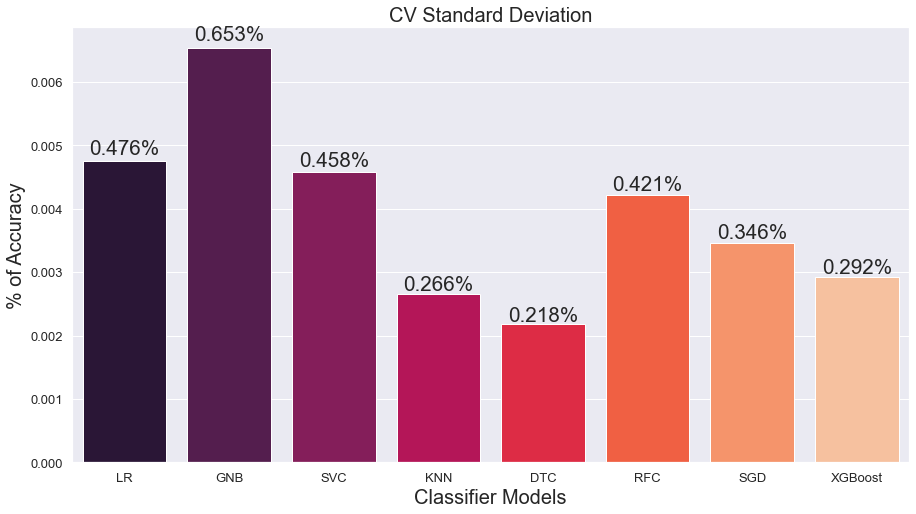

In [41]:
plotEvaluationMetrics(models,CVSD,"CV Standard Deviation")

## Extra Tree Feature Selection

<function matplotlib.pyplot.show(*args, **kw)>

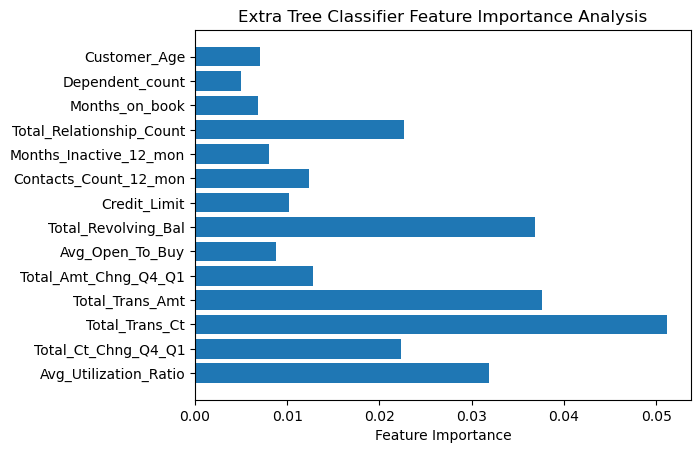

In [42]:
from sklearn.ensemble import ExtraTreesClassifier
extraTreeFeature = x_train_process[num_cols]

normalised_feature_importances = []

etc= ExtraTreesClassifier(random_state=0)
etc.fit(x_train_process[num_cols],y_train)
feature_importance=etc.feature_importances_
normalised_feature_importances= np.std([tree.feature_importances_ for tree in 
                                    etc.estimators_],axis=0)
plt.rcdefaults()
fig, ax = plt.subplots()
item=np.arange(len(extraTreeFeature.columns))
#horizontal bar chart
plt.barh(item,normalised_feature_importances)
ax.set_yticks(item)
ax.set_yticklabels(extraTreeFeature.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Feature Importance")
ax.set_title("Extra Tree Classifier Feature Importance Analysis")
plt.show

In [43]:
# every model accuracy graph
models = ['LR','GNB','SVC','KNN', 'DTC', 'RFC', 'SGD','XGBoost']
# Visualising the accuracy score of each classification model

In [44]:
d = {'Columns':num_cols,'Scores':normalised_feature_importances}
ExtraTreedf = pd.DataFrame(d).sort_values('Scores', ascending=True).head(6)

# drop least importance columns
x_etc_train = x_train_process.copy()
x_etc_test = x_test_process.copy()

for index, row in ExtraTreedf.iterrows():
    x_etc_train.drop(row['Columns'], axis=1, inplace=True)
    x_etc_test.drop(row['Columns'], axis=1, inplace=True)


Training time: 0.08927059173583984s
Accuracy score: 0.902
Precision score: 0.914
Recall score: 0.975
F1 score: 0.944
Training Accuracy:  0.8996896162528216
Testing Accuracy:  0.9022704837117473
              precision    recall  f1-score   support

       churn       0.80      0.52      0.63       488
   not churn       0.91      0.97      0.94      2551

    accuracy                           0.90      3039
   macro avg       0.86      0.75      0.79      3039
weighted avg       0.90      0.90      0.89      3039



LogisticRegression(max_iter=10000)

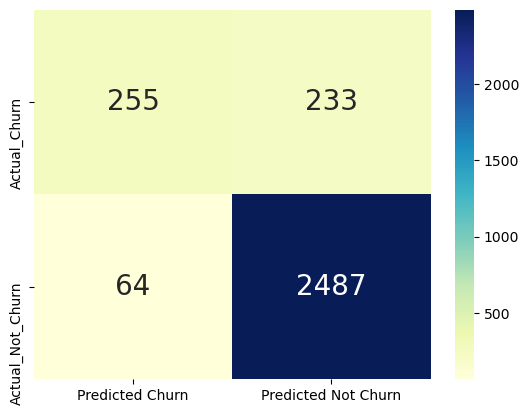

In [45]:
#LR after extra tree feature selection
acscore = []
acprecision = []
acrecall = []
acF1 = []
acTrainingTime = []
from sklearn.linear_model import LogisticRegression
model_training(LogisticRegression(max_iter=10000),x_etc_train,x_etc_test)

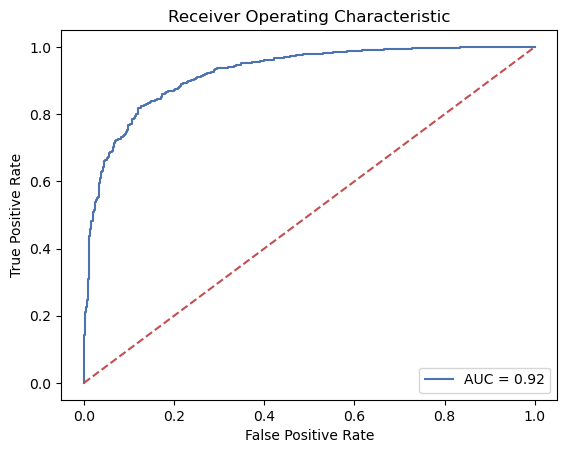

In [46]:
model_roc_curve(LogisticRegression(max_iter=10000),x_etc_train,x_etc_test)

Training time: 0.005985260009765625s
Accuracy score: 0.885
Precision score: 0.937
Recall score: 0.925
F1 score: 0.931
Training Accuracy:  0.8751410835214447
Testing Accuracy:  0.8845014807502468
              precision    recall  f1-score   support

       churn       0.63      0.67      0.65       488
   not churn       0.94      0.93      0.93      2551

    accuracy                           0.88      3039
   macro avg       0.78      0.80      0.79      3039
weighted avg       0.89      0.88      0.89      3039



GaussianNB()

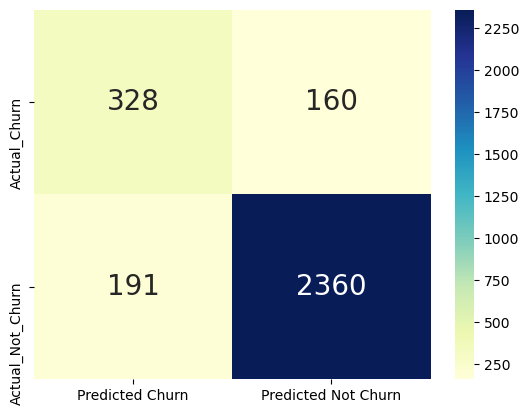

In [47]:
#Gaussian Naive Bayes after extra tree feature selection
model_training(GaussianNB(),x_etc_train,x_etc_test)

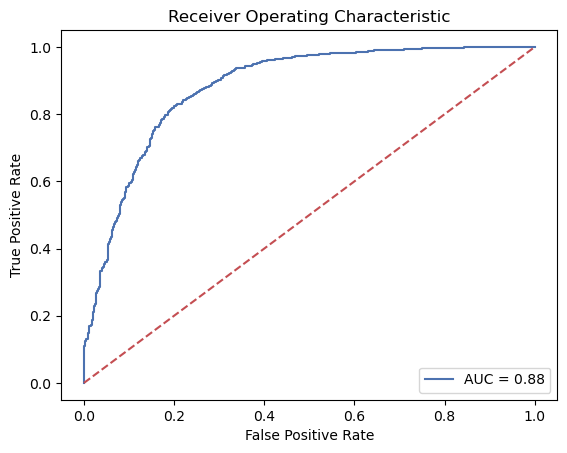

In [48]:
model_roc_curve(GaussianNB(),x_etc_train,x_etc_test)

Training time: 3.853985548019409s
Accuracy score: 0.892
Precision score: 0.891
Recall score: 0.992
F1 score: 0.939
Training Accuracy:  0.8872742663656885
Testing Accuracy:  0.8917407041790063
              precision    recall  f1-score   support

       churn       0.90      0.37      0.52       488
   not churn       0.89      0.99      0.94      2551

    accuracy                           0.89      3039
   macro avg       0.90      0.68      0.73      3039
weighted avg       0.89      0.89      0.87      3039



SVC(probability=True)

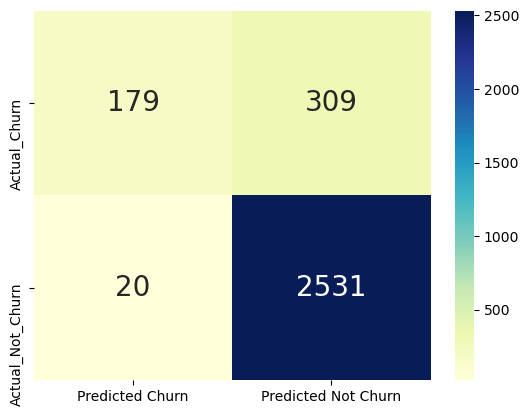

In [49]:
#SVC after extra tree feature selection
model_training(SVC(probability=True),x_etc_train,x_etc_test)

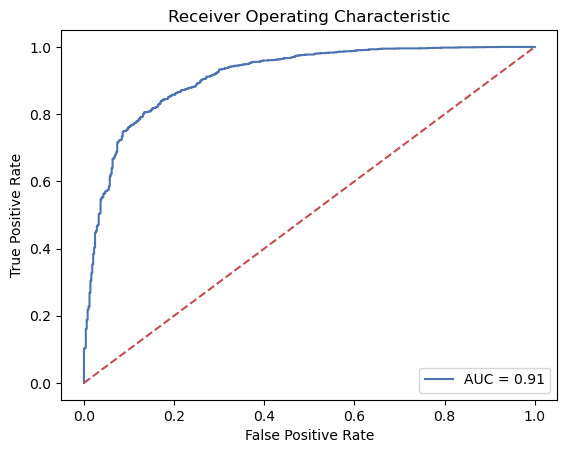

In [50]:
model_roc_curve(SVC(probability=True),x_etc_train,x_etc_test)

Training time: 0.03390002250671387s
Accuracy score: 0.869
Precision score: 0.882
Recall score: 0.974
F1 score: 0.926
Training Accuracy:  0.889813769751693
Testing Accuracy:  0.8687068114511353
              precision    recall  f1-score   support

       churn       0.70      0.32      0.44       488
   not churn       0.88      0.97      0.93      2551

    accuracy                           0.87      3039
   macro avg       0.79      0.65      0.68      3039
weighted avg       0.85      0.87      0.85      3039



KNeighborsClassifier()

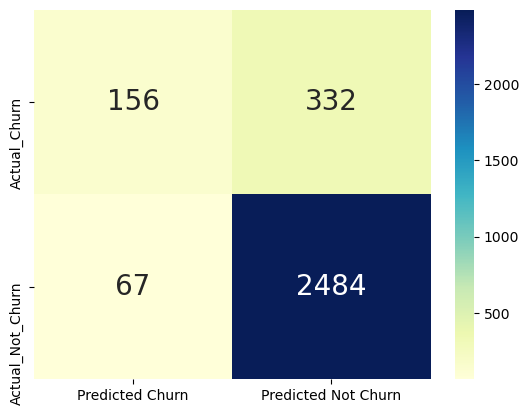

In [51]:
#KNN after extra tree feature selection
model_training(KNeighborsClassifier(),x_etc_train,x_etc_test)

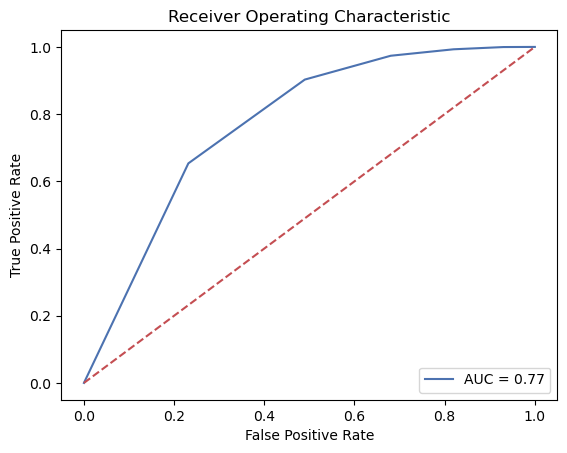

In [52]:
model_roc_curve(KNeighborsClassifier(),x_etc_train,x_etc_test)

Training time: 0.03297543525695801s
Accuracy score: 0.934
Precision score: 0.959
Recall score: 0.962
F1 score: 0.961
Training Accuracy:  1.0
Testing Accuracy:  0.9338598223099703
              precision    recall  f1-score   support

       churn       0.80      0.79      0.79       488
   not churn       0.96      0.96      0.96      2551

    accuracy                           0.93      3039
   macro avg       0.88      0.87      0.88      3039
weighted avg       0.93      0.93      0.93      3039



DecisionTreeClassifier()

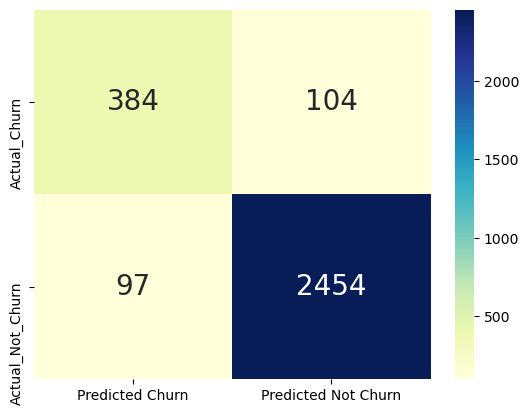

In [53]:
#DTC after extra tree feature selection
model_training(DecisionTreeClassifier(),x_etc_train,x_etc_test)

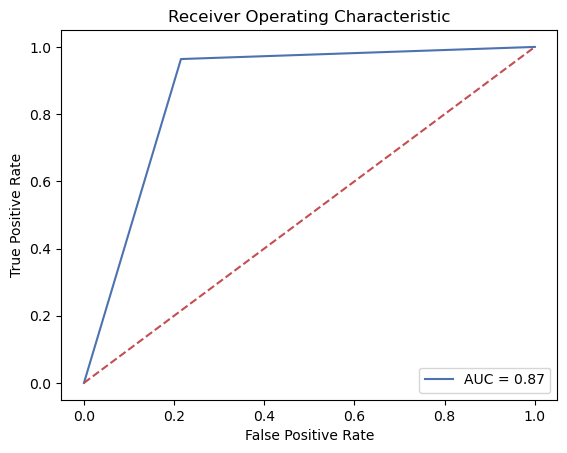

In [54]:
model_roc_curve(DecisionTreeClassifier(),x_etc_train,x_etc_test)

Training time: 0.8893444538116455s
Accuracy score: 0.959
Precision score: 0.968
Recall score: 0.984
F1 score: 0.976
Training Accuracy:  1.0
Testing Accuracy:  0.9591971043106285
              precision    recall  f1-score   support

       churn       0.91      0.83      0.87       488
   not churn       0.97      0.98      0.98      2551

    accuracy                           0.96      3039
   macro avg       0.94      0.91      0.92      3039
weighted avg       0.96      0.96      0.96      3039



RandomForestClassifier()

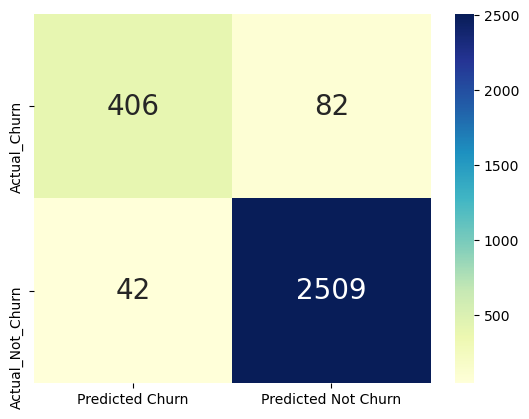

In [55]:
#RFC after extra tree feature selection
model_training(RandomForestClassifier(),x_etc_train,x_etc_test)

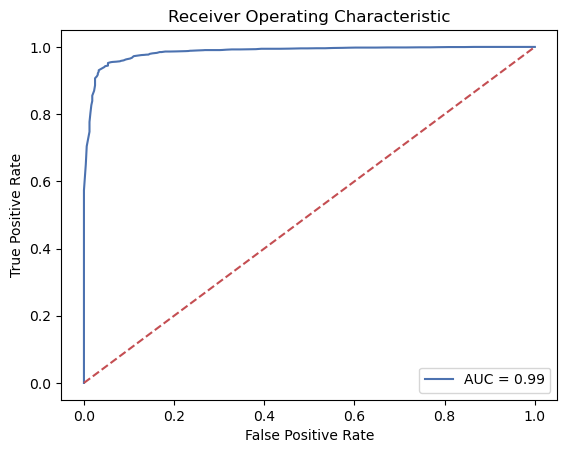

In [56]:
model_roc_curve(RandomForestClassifier(),x_etc_train,x_etc_test)

Training time: 0.028041839599609375s
Accuracy score: 0.899
Precision score: 0.916
Recall score: 0.969
F1 score: 0.942
Training Accuracy:  0.8991252821670429
Testing Accuracy:  0.8993089832181639
              precision    recall  f1-score   support

       churn       0.77      0.54      0.63       488
   not churn       0.92      0.97      0.94      2551

    accuracy                           0.90      3039
   macro avg       0.84      0.75      0.79      3039
weighted avg       0.89      0.90      0.89      3039



SGDClassifier(loss='log', shuffle=False)

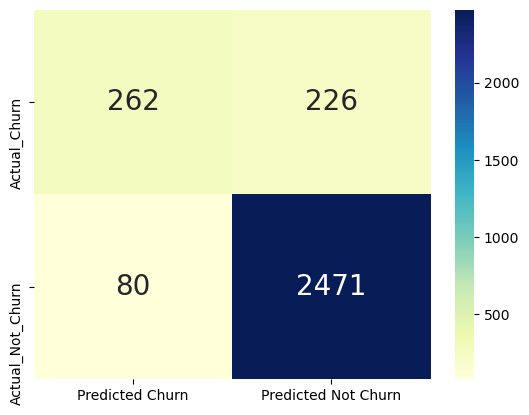

In [57]:
#SGD after extra tree feature selection
model_training(SGDClassifier(shuffle=False,loss="log"),x_etc_train,x_etc_test)

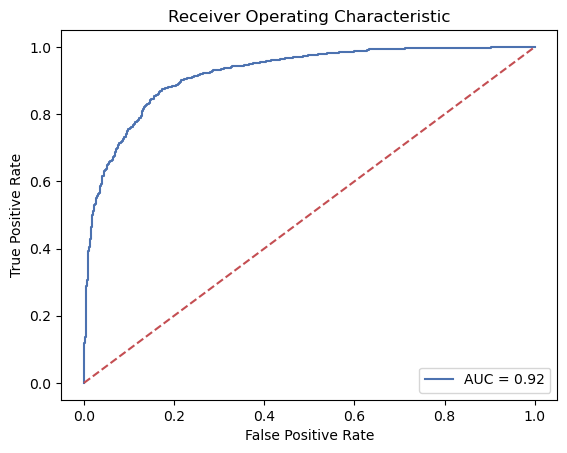

In [58]:
model_roc_curve(SGDClassifier(shuffle=False,loss="log"),x_etc_train,x_etc_test)

C:\Users\nigel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 0.6153976917266846s
Accuracy score: 0.966
Precision score: 0.976
Recall score: 0.983
F1 score: 0.980
Training Accuracy:  0.9998589164785553
Testing Accuracy:  0.9657782165185916
              precision    recall  f1-score   support

       churn       0.91      0.88      0.89       488
   not churn       0.98      0.98      0.98      2551

    accuracy                           0.97      3039
   macro avg       0.94      0.93      0.94      3039
weighted avg       0.97      0.97      0.97      3039



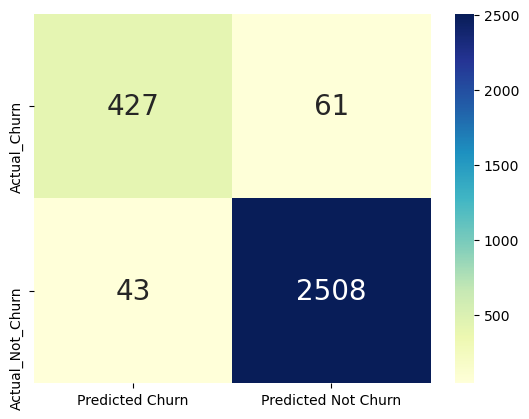

In [59]:
#XGB after extra tree feature selection
xgbmodel = model_training(xgb.XGBClassifier(),x_etc_train,x_etc_test)

[23:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


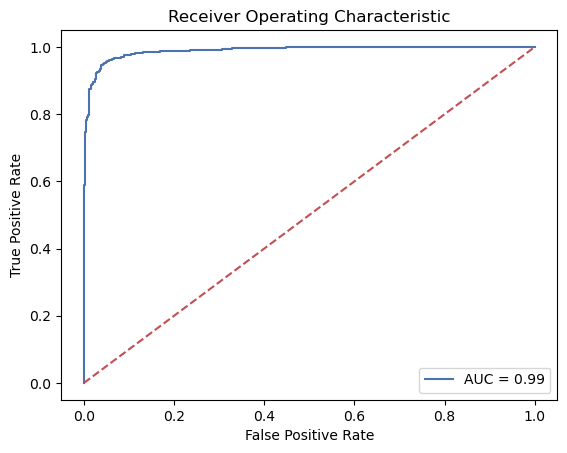

In [60]:
model_roc_curve(xgb.XGBClassifier(),x_etc_train,x_etc_test)

In [61]:
x_process_concat = pd.concat([x_etc_train,x_etc_test])
y_concat =  np.concatenate((y_train, y_test), axis=None)

In [62]:
from sklearn.model_selection import cross_val_score

CVMean = []
CVSD = []

tupleModel = [LogisticRegression(random_state=0,max_iter=10000),GaussianNB(),SVC(probability=True),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),SGDClassifier(loss="log"),xgb.XGBClassifier()]
a = 0
for model in models:
    model = cross_val_score(tupleModel[a],x_process_concat, y_concat,cv=5,scoring='accuracy')
    print(models[a],":",model)
    CVMean.append(model.mean())
    CVSD.append(model.std())
    a+=1

LR : [0.89536032 0.89486673 0.9017284  0.90617284 0.90419753]
GNB : [0.87068115 0.87068115 0.87851852 0.87407407 0.8908642 ]
SVC : [0.88302073 0.8899309  0.89037037 0.89382716 0.89234568]
KNN : [0.87166831 0.86179664 0.86469136 0.87012346 0.87654321]
DTC : [0.93978282 0.93830207 0.94123457 0.9382716  0.93925926]
RFC : [0.95261599 0.95853899 0.95555556 0.95802469 0.96246914]
SGD : [0.89684107 0.85932873 0.8982716  0.90666667 0.89481481]
[23:26:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\nigel\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

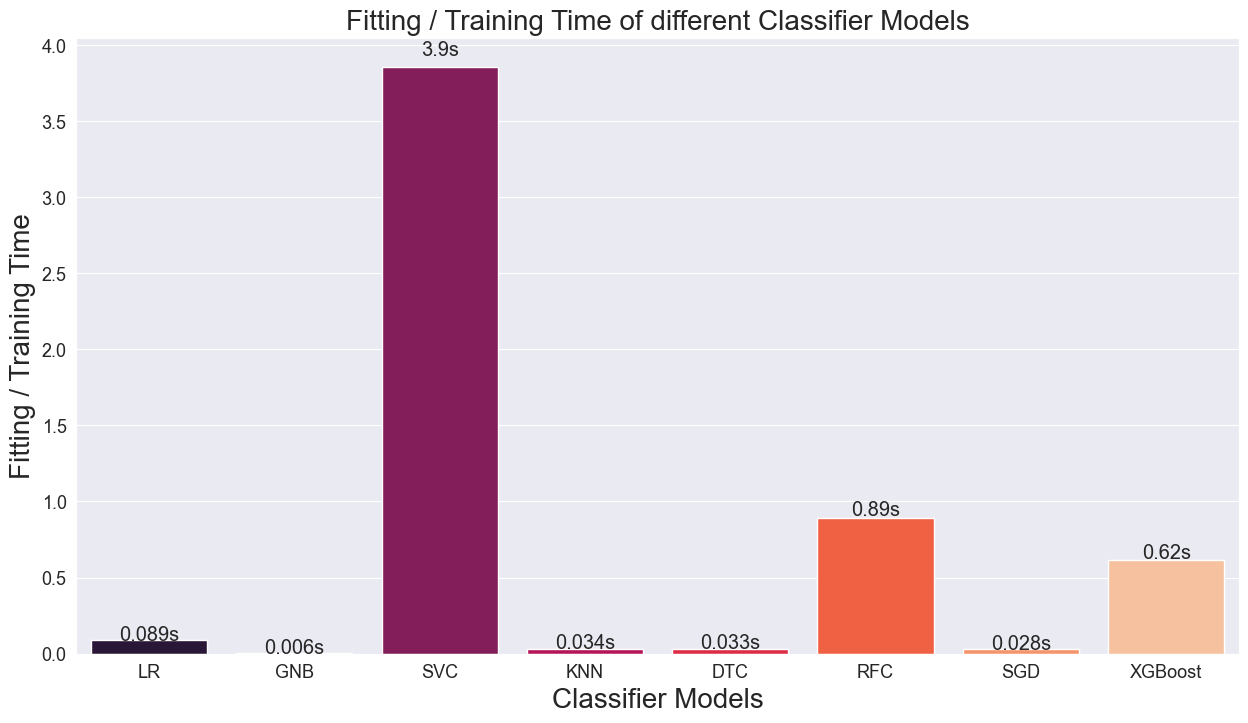

In [63]:
plt.rcParams['figure.figsize']=15,8 
sns.set_style("darkgrid")
ax = sns.barplot(x=models, y=acTrainingTime, palette = "rocket", saturation =1.5)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("Fitting / Training Time", fontsize = 20)
plt.title("Fitting / Training Time of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    xPlot, yPlot = p.get_xy() 
    ax.annotate(f'{height:.2}''s', (xPlot + width/2, yPlot + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

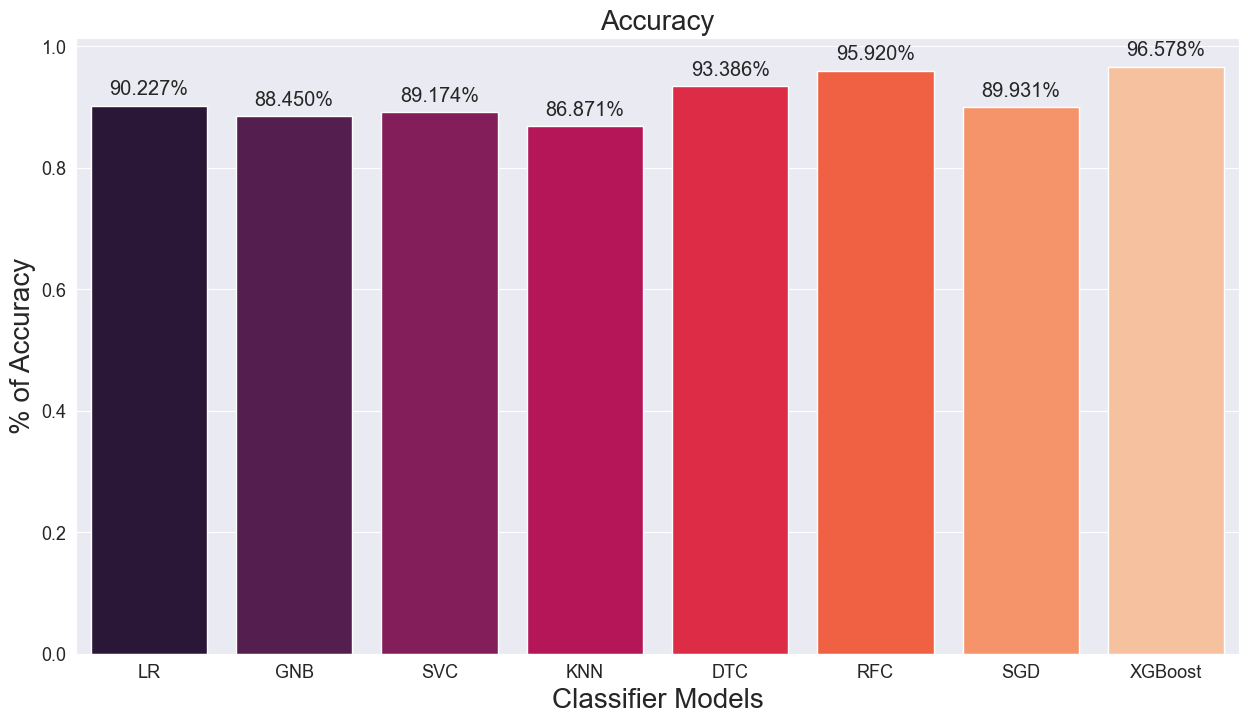

In [64]:
plotEvaluationMetrics(models,acscore,"Accuracy")

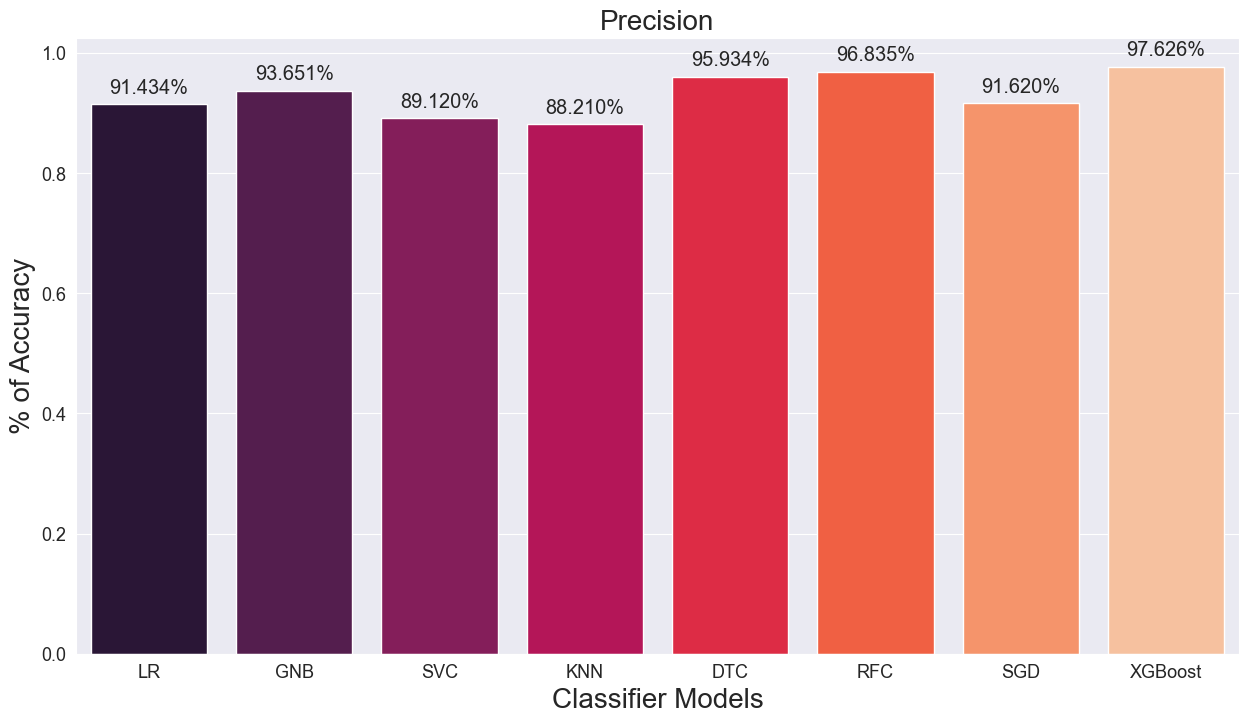

In [65]:
plotEvaluationMetrics(models,acprecision,"Precision")

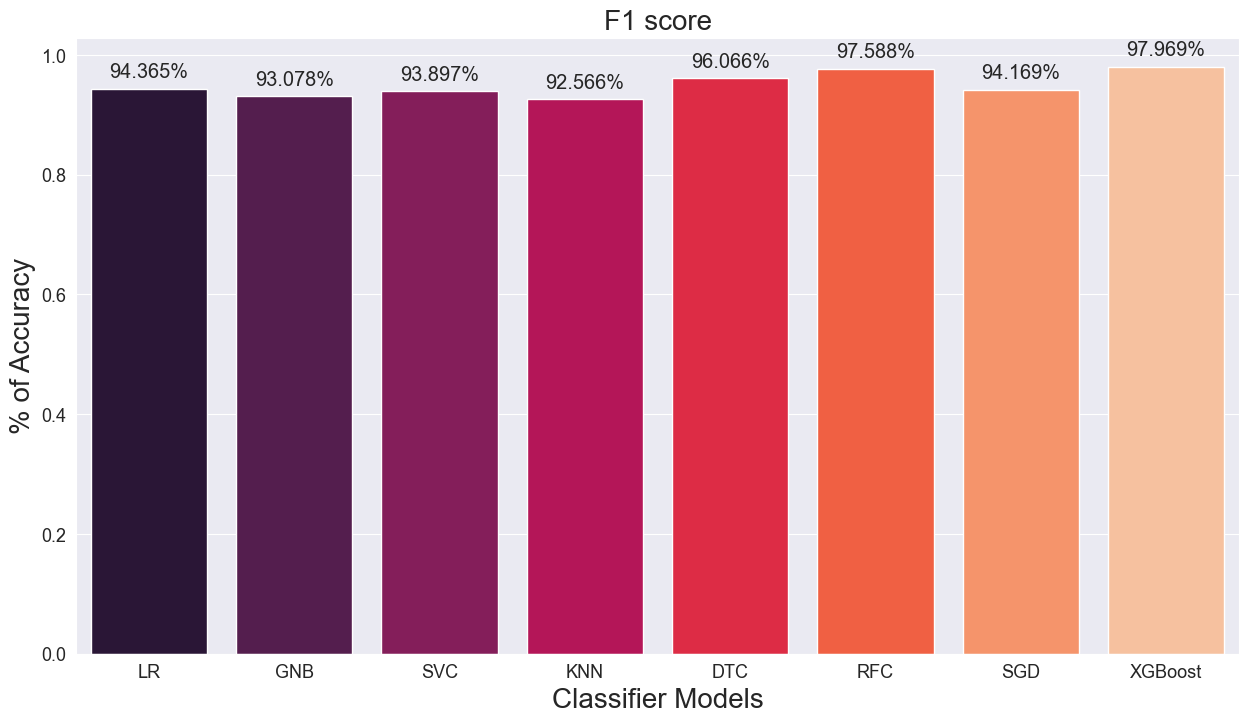

In [66]:
plotEvaluationMetrics(models,acF1,"F1 score")

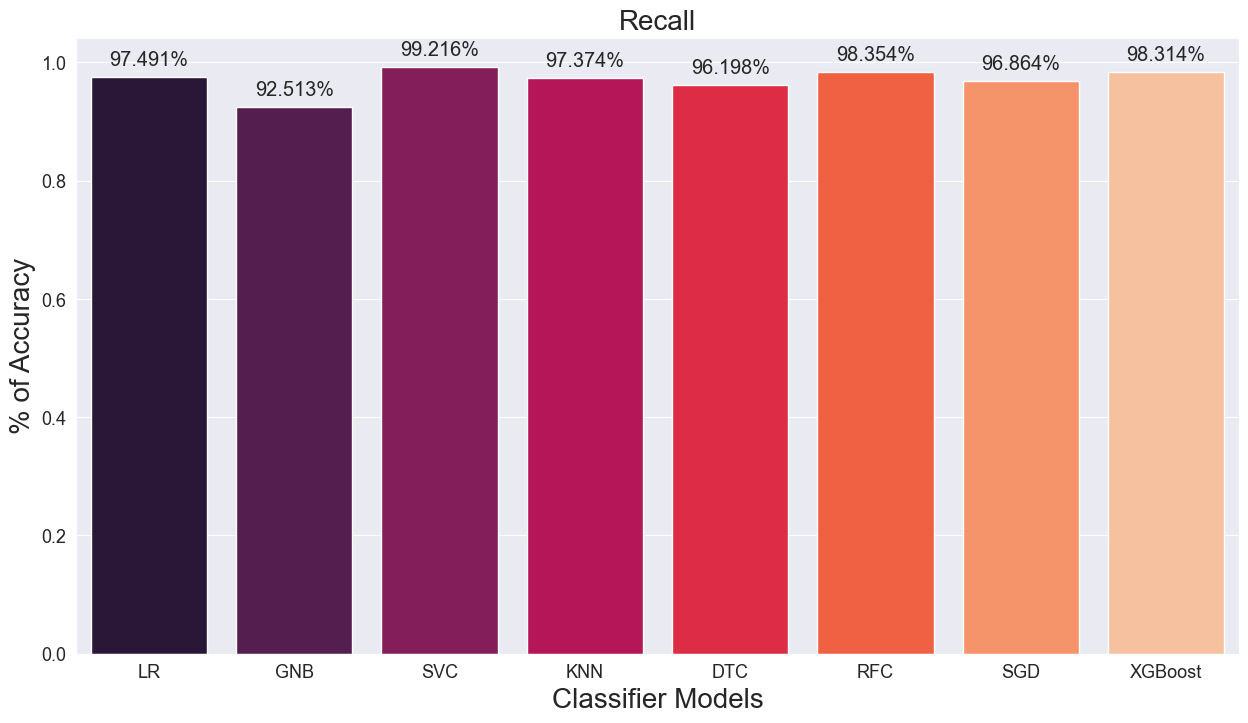

In [67]:
plotEvaluationMetrics(models,acrecall,"Recall")

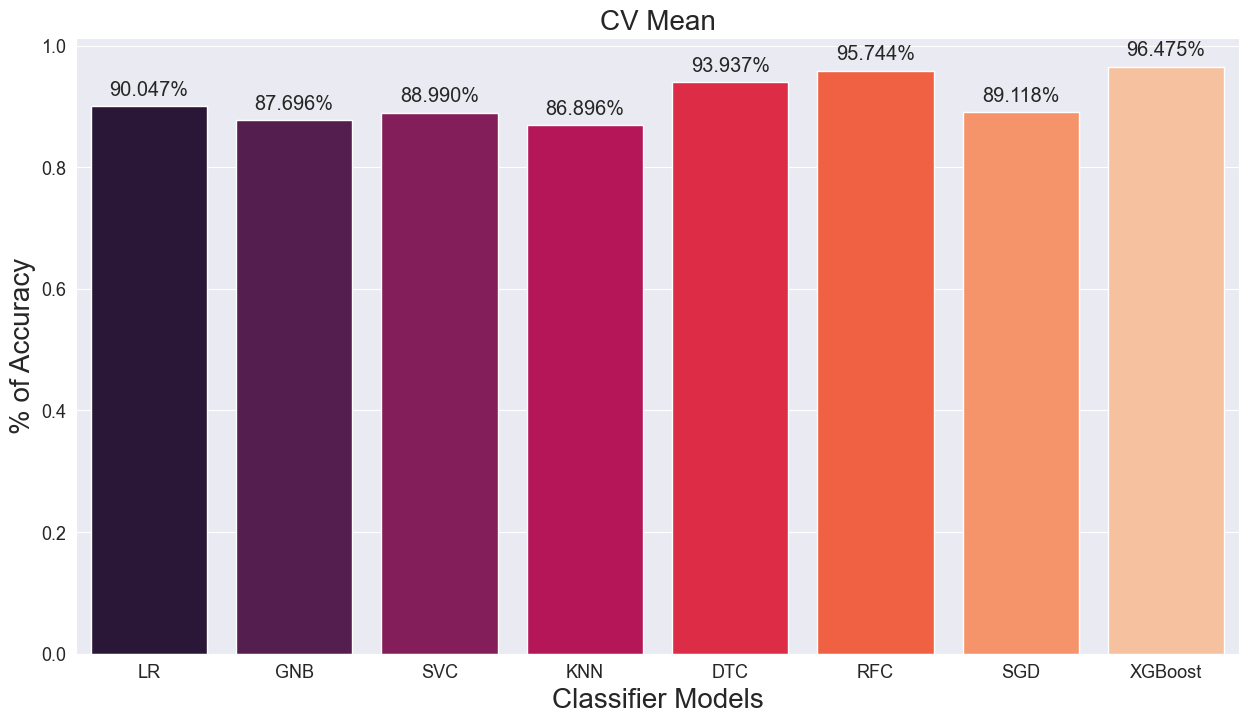

In [68]:
plotEvaluationMetrics(models,CVMean,"CV Mean")

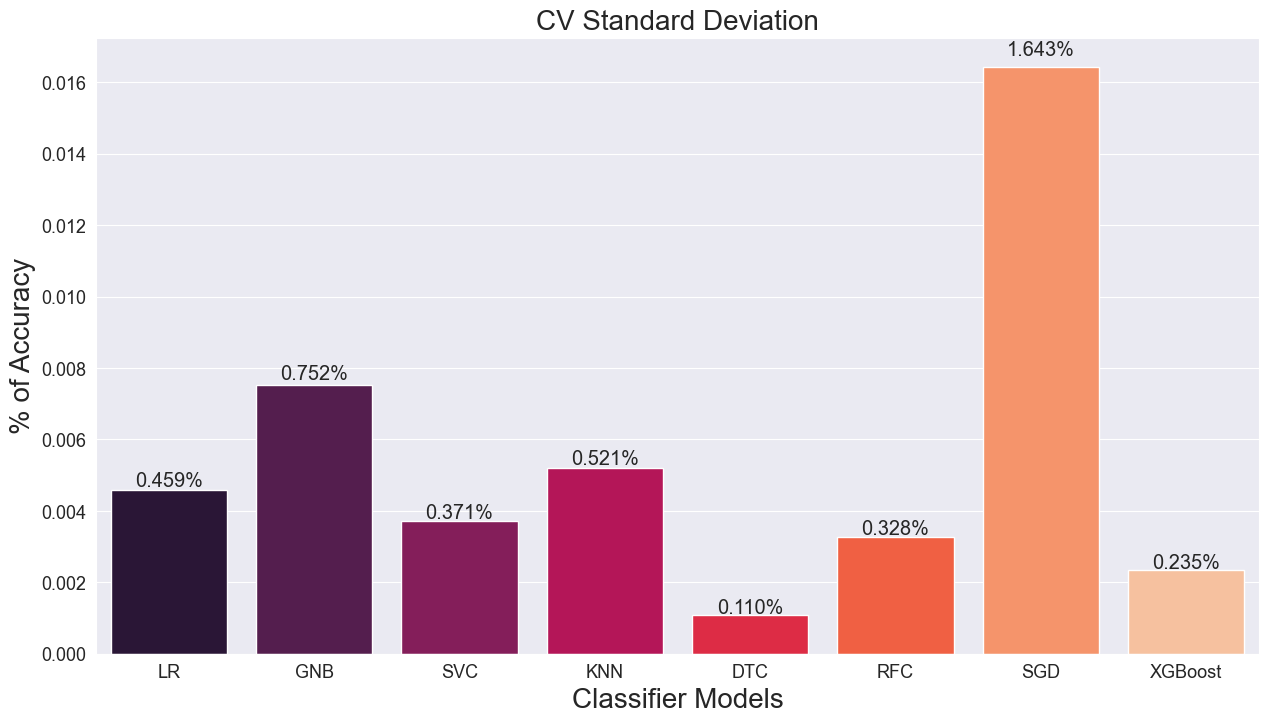

In [69]:
plotEvaluationMetrics(models,CVSD,"CV Standard Deviation")

In [70]:
import joblib

def save_model(model, fileName):
    # Save Model to file in the current working directory
    joblib.dump(model, fileName)
    
def load_model(fileName,x_test,ytest):    
    # Load from file
    joblib_model = joblib.load(fileName)
    print(joblib_model,' ','\n')
    
    y_pred = joblib_model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    ac = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    sns.heatmap(cm, xticklabels=['Predicted Churn', 'Predicted Not Churn'], yticklabels=['Actual_Churn', 'Actual_Not_Churn'],
            annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    print('Accuracy score: {0:0.3f}'.format(ac))
    print('Precision score: {0:0.3f}'.format(precision))
    print('Recall score: {0:0.3f}'.format(recall))
    print('F1 score: {0:0.3f}'.format(f1))
    print('Testing Accuracy: ',joblib_model.score(x_test, y_test))
    target_names = ['churn', 'not churn']
    print(classification_report(y_test, y_pred, target_names=target_names))

In [71]:
fileName ="joblib_Model1.pkl"
save_model(xgbmodel,fileName)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)   

Accuracy score: 0.966
Precision score: 0.976
Recall score: 0.983
F1 score: 0.980
Testing Accuracy:  0.9657782165185916
              precision    recall  f1-score   support

       churn       0.91      0.88      0.89       488
   not churn       0.98      0.98      0.98      2551

    accuracy                           0.97      3039
   macro avg       0.94      0.93      0.94      3039
weighted avg       0.97

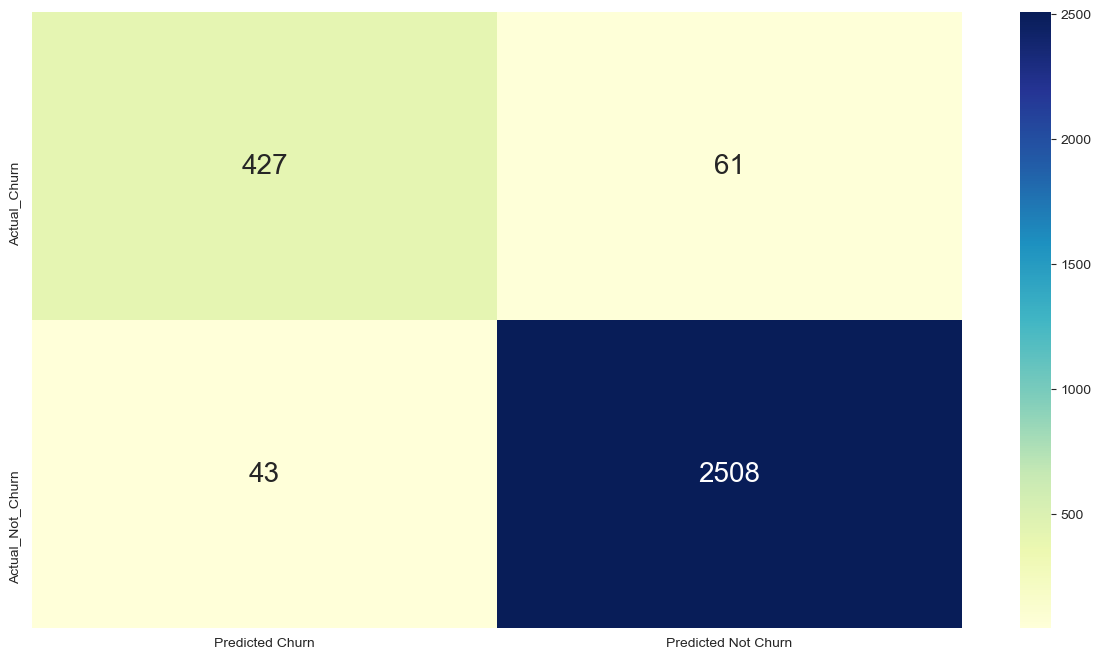

In [72]:
load_model(fileName,x_etc_test,y_test)

In [73]:
fileName ="joblib_Model.pkl"
save_model(xgbmodel1,fileName)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)   

Accuracy score: 0.934
Precision score: 0.949
Recall score: 0.973
F1 score: 0.961
Testing Accuracy:  0.9338598223099703
              precision    recall  f1-score   support

       churn       0.84      0.73      0.78       488
   not churn       0.95      0.97      0.96      2551

    accuracy                           0.93      3039
   macro avg       0.89      0.85      0.87      3039
weighted avg       0.93

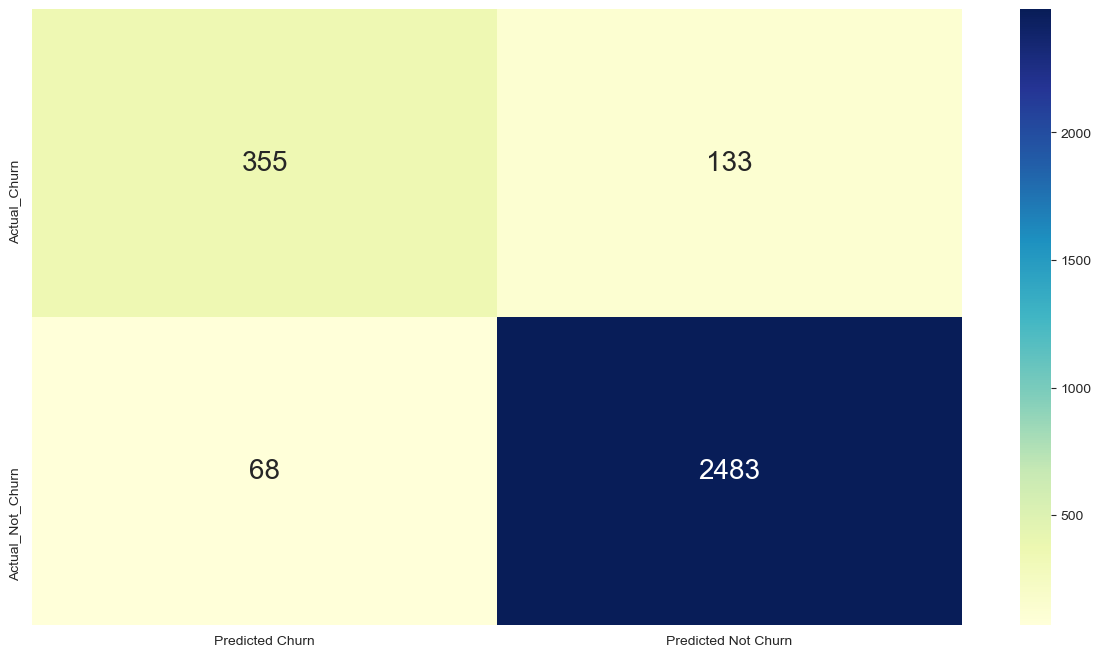

In [74]:
load_model(fileName,x_test_nw,y_test)